<a href="https://colab.research.google.com/github/ak-org/notebooks/blob/master/pytorch_cifar10_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
print(torch.__version__)

1.2.0


In [3]:
transform = transforms.Compose([ 
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(), #63% accuracy without random crop and flip
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


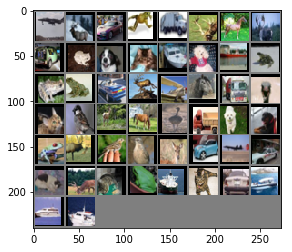

plane  deer   car  frog truck  deer horse  deer   car  frog   dog   cat  ship   dog  ship  frog  frog  frog   car  deer plane horse truck  bird   cat  bird  deer horse  bird truck   dog   dog  frog  deer  bird  bird  deer   car plane   car   cat  deer   cat  frog  ship   cat   car  ship  ship  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(50)))

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [0]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x 

#net = Net()
 

In [0]:
class Block(nn.Module):
    '''expand + depthwise + pointwise + squeeze-excitation'''

    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1,
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_planes, out_planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_planes//16, out_planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(cfg[-1][1], num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def EfficientNetB0():
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 2),
           (6,  24, 2, 1),
           (6,  40, 2, 2),
           (6,  80, 3, 2),
           (6, 112, 3, 1),
           (6, 192, 4, 2),
           (6, 320, 1, 2)]
    return EfficientNet(cfg)

net = EfficientNetB0()

In [0]:
## define a loss and optimizer
import torch.optim as optim 
crit = nn.CrossEntropyLoss()
optim = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is ", device)
if torch.cuda.is_available() == True:
  print("Moving model to GPU")
  net = net.to(device)
  net = torch.nn.DataParallel(net)
  cudnn.benchmark = True
else:
  print("Unable to find matching CUDA")

Device is  cuda:0
Moving model to GPU


In [10]:
n_epochs = 10
net = net.to(device)
for epoch in range(n_epochs):
  running_loss = 0.0
  for i, data in tqdm(enumerate(trainloader, 0)):
    inputs, labels = data[0].to(device), data[1].to(device)
    optim.zero_grad()

    outputs = net(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    optim.step()
    running_loss += loss.item() 
  print("Epoch : {}, loss = {}".format(epoch, running_loss/1000))

1000it [01:31, 11.48it/s]
2it [00:00, 11.49it/s]

Epoch : 0, loss = 1.7588895092010497


1000it [01:29, 11.04it/s]
1it [00:00,  9.19it/s]

Epoch : 1, loss = 1.4353277062177658


1000it [01:30, 11.06it/s]
2it [00:00, 11.10it/s]

Epoch : 2, loss = 1.2920009441375733


1000it [01:27, 11.79it/s]
2it [00:00, 11.96it/s]

Epoch : 3, loss = 1.1891822741031646


1000it [01:27, 11.58it/s]
2it [00:00, 11.94it/s]

Epoch : 4, loss = 1.1170705295801162


1000it [01:26, 11.45it/s]
2it [00:00, 11.77it/s]

Epoch : 5, loss = 1.0508233330249785


1000it [01:27, 10.97it/s]
2it [00:00, 10.74it/s]

Epoch : 6, loss = 0.9912972722053528


1000it [01:29, 11.09it/s]
2it [00:00, 11.06it/s]

Epoch : 7, loss = 0.9433608238697052


1000it [01:29, 11.41it/s]
2it [00:00, 11.62it/s]

Epoch : 8, loss = 0.8936309344470501


1000it [01:29, 11.57it/s]

Epoch : 9, loss = 0.859013285458088


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [13]:
images[0].shape, classes[labels[0]]

(torch.Size([3, 32, 32]), 'cat')

In [0]:
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
#_, predicted = torch.max(outputs, 1)
#print("Predicted : ", classes[predicted])

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 75 %
Accuracy of  bird : 60 %
Accuracy of   cat : 54 %
Accuracy of  deer : 69 %
Accuracy of   dog : 50 %
Accuracy of  frog : 83 %
Accuracy of horse : 73 %
Accuracy of  ship : 85 %
Accuracy of truck : 73 %
